In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
from scipy.optimize import curve_fit
os.getcwd()

'/Users/edwardmu/OneDrive - Stanford/Classes/Chem 274 - Echem Lab/Project/Github/CHEM274-20211130'

In [2]:
data = pd.read_csv('data/CA_Fc_GC_MeCN_0V-1.2V_P-06-14/data.csv', sep=',')
data

,Unnamed: 0,E_program,Ecell,iw,t
0,0,0.0,0.000344,3.442151e-07,0.000000
1,1,0.0,0.000015,1.525869e-08,0.000278
2,2,0.0,-0.000314,6.731716e-07,0.000556
3,3,0.0,0.000015,1.525869e-08,0.000833
4,4,0.0,0.000344,3.442151e-07,0.001111
...,...,...,...,...,...
867595,867595,1.2,1.200049,3.633780e-06,240.998611
867596,867596,1.2,1.200707,3.633780e-06,240.998889
867597,867597,1.2,1.200049,3.633780e-06,240.999167
867598,867598,1.2,1.200707,3.962736e-06,240.999444


<AxesSubplot:xlabel='t'>

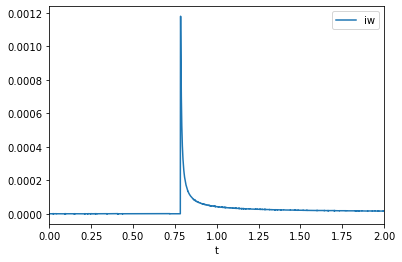

In [17]:
data.plot('t', 'iw', xlim=(0,2))

In [24]:
index_max = data['iw'].idxmax()
time_max = data.loc[index_max,'t']
print(time_max)

0.7841666666666667


In [20]:
# In E4, near optimal values of Rm and Cm were:
Rm = 10000 #10 kOhm
Cm = 100e-9 #100 nF
pstat_time_constant = Rm*Cm

# From Fe(acac)3 data in wet MeCN, Ru and Cdl were approximately:
Ru = 530
Cdl = 4.58e-6
cell_time_constant = Ru*Cdl

#Value of the combined time constant tau

print(cell_time_constant + pstat_time_constant)

0.0034274


In [25]:
pot_step_time = time_max # step time start in s
pot_rest_time = data.iloc[-1,-1] # rest time start in s

# For both of these capacitors to charge, we should ignore data before at least 5τ of each:
fit_start_time = pot_step_time + (5 * (cell_time_constant + pstat_time_constant))

# Fit until 5 ms before the rest step
fit_times = data[data['t'].between(fit_start_time, pot_rest_time - 0.005)]['t'].to_numpy()
fit_currents = data[data['t'].between(fit_start_time, pot_rest_time - 0.005)]['iw'].to_numpy()

fit_times_no_offset = fit_times - pot_step_time
#print(fit_times_no_offset)

a = 2.490E-05
D = 3.393E-05 cm^2 s^-1


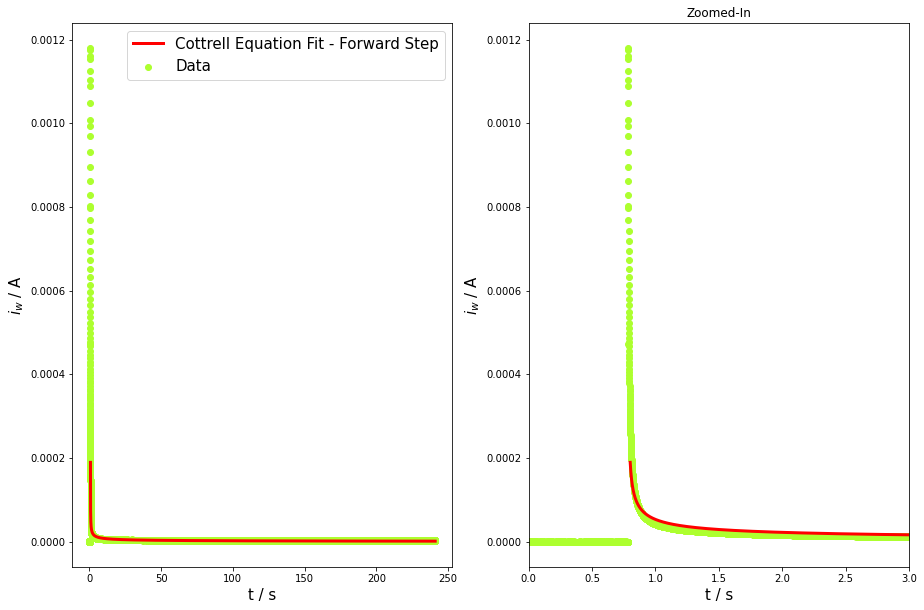

In [32]:
#Defines a function for curve_fit to fit to

def Empirical_Cottrell(t, a):
    return a / np.sqrt(t)

#Implementing curve_fit to solve for the empirical Cottrell prefactor a

guess_prefactor = 1e-10
fit_prefactor, cov = curve_fit(Empirical_Cottrell, fit_times_no_offset, fit_currents, guess_prefactor)
print('a = {0:.3E}'.format(fit_prefactor[0]))

#Calculating the diffusion constant D based on the fitted prefactor a, and the Cottrell Equation

a = fit_prefactor[0]
n = 1
F = 96485 #C/mol
A = np.pi*2.5**2/1000**2 #m^2
C_bulk = 0.4 #mol*m^-2
D = (a**2 * np.pi) / (n*F*A*C_bulk)**2 * 100**2 #cm^2/s
print('D = {0:.3E}'.format(D) + ' cm^2 s^-1')

#Plotting the chronoamperometry curve with the Cottrell Equation fit

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,10))
ax1.scatter(data['t'], data['iw'], label = 'Data', color = 'greenyellow')
ax1.set_ylabel('$i_w$ / A', fontsize = 15)
ax1.set_xlabel('t / s', fontsize = 15)
#ax.set_xlim(.99, 2.01)
ax1.plot(fit_times, Empirical_Cottrell(fit_times_no_offset,a), color='red', label = 'Cottrell Equation Fit - Forward Step', linewidth=3)
ax1.legend(fontsize = 15)

ax2.scatter(data['t'], data['iw'], label = 'Data', color = 'greenyellow')
ax2.set_title('Zoomed-In')
ax2.set_ylabel('$i_w$ / A', fontsize = 15)
ax2.set_xlabel('t / s', fontsize = 15)
ax2.set_xlim(0, 3)
ax2.plot(fit_times, Empirical_Cottrell(fit_times_no_offset,a), color='red', label = 'Cottrell Equation Fit - Forward Step', linewidth=3)
#ax2.legend(fontsize = 15)